# Neural Network Implementation 1

Hi! Welcome to the first implementation of our multi-layer neural network. In this implementation, we will apply the feedforward backpropagation algorithm to plot a **decision boundary** on a classification problem. A decision boundary is basically a line that separates one class from another. Below is a visualization of the concept.

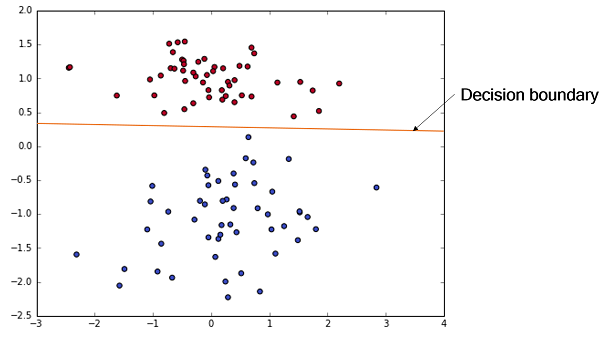

In [141]:
from IPython.display import Image
Image('decisionboundary.png')

In [14]:
# Import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

## Constructing a dataset

The sklearn.datasets module includes a wide variety of utilities to load and generate datasets. Examples of popular datasets include handwriting classification, housing prices, and face images. Some useful data generators include the make_classification, make_regression, and make_blobs function, which generates a classification, regression, or clustering problem like the name suggests.

For our implementation, we will construct a dataset that requires a nonlinear boundary decision in which algorithms like logistic regression would not work well. We will do this using the make_gaussian_quantiles function. <sub>(Quantile is just a fancy word for group.)</sub> What the code below does is create two datasets and join them together.

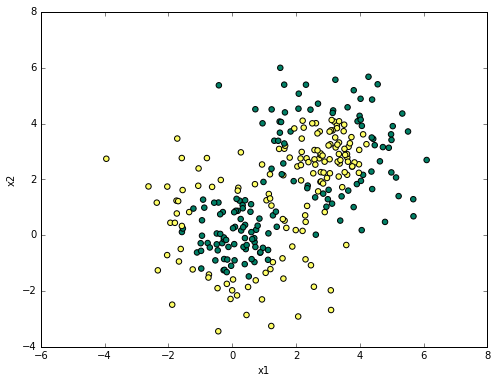

In [145]:
# Construct dataset
# Code by Noel Dawe

X1, y1 = sklearn.datasets.make_gaussian_quantiles(cov=2., n_samples=150, n_features=2,
                                                 n_classes=2, random_state=1)
X2, y2 = sklearn.datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=150, n_features=2,
                                                 n_classes=2, random_state=1)

# Join the two datasets
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2+1))

plt.scatter(X[:, 0], X[:, 1],c=y, s=30, cmap=plt.cm.summer)
plt.xlabel('x1')
plt.ylabel('x2')

## Test on Logistic Regression

Logistic regression is one of the most essential models which can classify inputs. It also uses the sigmoid function, btu it is a simpler model than the neural network. Let's try using logistic regression to classify our dataset. The code below uses the built-in sklearn logistic regression implementation to fit the data.

The plot_decision_boundary function gives the countour plot shown below. (Don't worry too much about the code if you don't understand it.) The color of the region corresponds to what the algorithm thinks the classification is. As you can see, it is not a very good fit of our data.

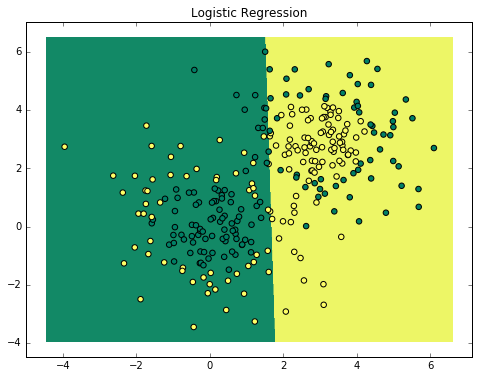

In [16]:
# Code by Denny Britz

clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.summer)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.summer)
    
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

## Cost Function

Let's first implement our cost function. Recall that we are using the cross-entropy loss function,

$$ J(z) = -y\log(g(z)) - (1-y)\log(1-(g(z)))$$

It is not necessary for our algorithm as a whole, but keeping track of errors over time will help us know if our network is being trained in the right direction. Also recall that $g(z)$ corresponds to the sigmoid function,

$$g(z) = \frac{1}{1+e^{-z}}$$

in which we would also need to code. Finally, since we have 2 classes, we would like to change our output $y^{(i)}$ for training example $i$ into a vector of 

$$
y^{(i)} = 
\begin{bmatrix}
1\\
0
\end{bmatrix}
if \ i \ is \ of \ class \ 1
$$

and

$$
y^{(i)} = 
\begin{bmatrix}
0\\
1
\end{bmatrix}
if \ i \ is \ of \ class \ 2
$$

In [164]:
def sigmoid(x):
    '''Returns the sigmoid of a matrix or real number x'''
    z = np.exp(-x)
    return 1/(1+z)

def changey(y):
    '''Changes vector y into a matrix of vectors.'''
    m = np.shape(y)[0]
    ynew = np.zeros((m,2))

    for i in np.arange(np.shape(y)[0]):
        ynew[i][y[i]] = 1
    
    return ynew

def costFunction(model, X, y):
    '''Returns the error between the predicted output and actual output'''
    w1, w2 = model['w1'], model['w2']
    m = np.shape(y)[0]
    
    # Add x0 term to input
    X = np.insert(X,0,1,axis=1)
    y = changey(y)

    # Forward propagation
    z2 = X.dot(w1.transpose()) 
    a2 = sigmoid(z2)        

    a2 = np.insert(a2,0,1,axis=1)    # Add a bias unit
    
    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    # Cost function over all training examples
    J = 0
    for i in range(m):
        J += -sum((y[i]*np.log(a3[i]) + (1-y[i])*np.log(1-a3[i])))
    
    return J/m


We also need a prediction function, which outputs the most probable classification. For instance, if we have a 3 classes (classes a, b, and c) and our predicted output is
$$
a^{(L)} = 
\begin{bmatrix}
0.0025\\ 
0.9925\\ 
0.005
\end{bmatrix}
$$
we want our network to classify it as class b.

In [165]:
def predict(model, X):
    '''Outputs the most probable classification'''
    
    X = np.insert(X,0,1,axis=1)
    w1, w2 = model['w1'], model['w2']
    
    #Forward propagation
    z2 = X.dot(w1.transpose())     
    a2 = sigmoid(z2)
    
    a2 = np.insert(a2,0,1,axis=1)  
    
    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    max_array = np.argmax(a3, axis=1)
    
    return max_array
    

We would also need to randomly initialize weights to small number - a weight matrix of all zeroes wouldn't work.

In [166]:
def randInitializeWeights(nodes_in, nodes_out):
    '''Randomly initializes a weight matrix'''
    
    w = np.random.randn(nodes_out, nodes_in+1)
    w /= np.sqrt(nodes_in)
    
    return w

Next up is the backpropagation algorithm - the essence of our neural network!

These are the three equations we will use, written to be specific to our network:
$$ \delta^{(3)} = a^{(3)}-y $$

$$\delta^{(2)} = w^{(2)T} \delta^{(3)} \odot g'(z^{(2)})$$

The third equation can be separated:
$$\frac{\partial J}{\partial w^{(1)}} =  a^{(1)} \delta^{(2)}$$

$$\frac{\partial J}{\partial w^{(2)}} =  a^{(2)} \delta^{(3)}$$

In [167]:
def Backpropagation(model, X, y):
    '''Performs backpropagation on the model'''
    # Initialize
    w1, w2 = model['w1'], model['w2']
    m = np.shape(y)[0]
    
    # Add x0 term to input
    X = np.insert(X,0,1,axis=1)
    y = changey(y)

    # Forward propagation
    z2 = X.dot(w1.transpose())
    a2 = sigmoid(z2)        

    a2 = np.insert(a2,0,1,axis=1)

    z3 = a2.dot(w2.transpose())
    a3 = sigmoid(z3)
    
    # Backpropagation
    delta3 = a3 - y
    delta2 = delta3.dot(w2) * (a2*(1-a2))
    
    # Remove bias unit
    delta2 = np.delete(delta2,0,axis=1)
    
    # Equation (1)
    w1_grad = delta2.transpose().dot(X) /m
    w2_grad = delta3.transpose().dot(a2) /m
    
    return w1_grad, w2_grad

Recall our gradient descent algorithm:
$$
\begin{align}
repeat \ until \ convergence: \\
\quad w_{j} := w_{j} - \alpha \frac{\partial J}{\partial w_{j}}
\end{align}
$$

Hey, now we're ready for the entire algorithm!

In [170]:
def NeuralNetworks(X, y, hidden_nodes, iterations, print_loss = False):
    '''A 3-layer neural network, returns the optimized weights'''
    
    # Randomly initialize weights
    w1 = randInitializeWeights(np.shape(X)[1], hidden_nodes)
    w2 = randInitializeWeights(hidden_nodes, 2)
    
    model = {'w1':w1, 'w2':w2}
    alpha = 0.05

    for i in range(iterations):
        
        w1_grad, w2_grad = Backpropagation(model, X, y)
        
        w1 += -alpha*w1_grad
        w2 += -alpha*w2_grad
        
        model = {'w1':w1, 'w2':w2}

        if print_loss:
            if i%10000==0:
                J = costFunction(model, X, y)
                print('Iteration: {}, Cost: {}'.format(i, J))
    
    return model
    

That's it! This is the most basic implementation of neural networks. Let's see how well it does with plotting a decision boundary. The default settings are of 5 nodes in the hidden layer. Try playing around with the number of nodes and see the difference!

Iteration: 0, Cost: 1.431065299421059
Iteration: 10000, Cost: 1.0098898506144143
Iteration: 20000, Cost: 0.6870902161501622
Iteration: 30000, Cost: 0.6190068086569868
Iteration: 40000, Cost: 0.5956990600069041
Iteration: 50000, Cost: 0.5793801961219515


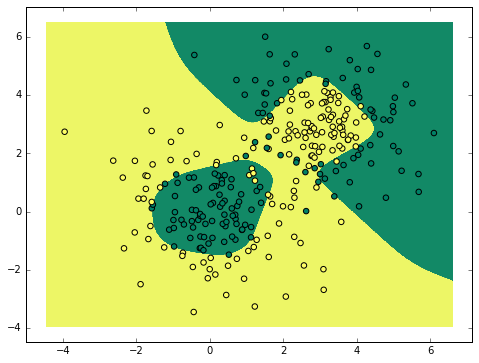

In [178]:
#############################################
# Trying changing the number of hidden nodes!
hidden_nodes = 5
#############################################

model = NeuralNetworks(X, y, hidden_nodes, 60000, print_loss=True)
plot_decision_boundary(lambda x: predict(model, x))

Not too bad! Keep in mind that there are several ways to still improve the performance of our network, two of which are regularization and cleverly initializing weights. They aren't that difficult to implement, but it might be too heavy for this already code-ridden section.

## References & Further Readings

- [Coursera: Machine Learning](https://www.coursera.org/learn/machine-learning)
- [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)
- [Scikit Dataset Loading Utilities](http://scikit-learn.org/stable/datasets/)
- [Scikit Learn API Reference](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)